# Step1) Prob map (픽셀별로 머리일 확률 도출) 만드는 첫번째 분류기 만들기

In [3]:
import numpy as np
from PIL import Image
import glob
import os 
# LOAD FILES AND MAKE IT AS NUMPY FILE
os.chdir('C:\\Users\\이보근\\Desktop\\빅데이터연구회\\2학기 딥러닝 1조\\프로젝트 자료\\texture')
dir_path= 'C:/Users/이보근/Desktop/빅데이터연구회/2학기 딥러닝 1조/프로젝트 자료/texture/Patch1k/Patch1k'
path = [dir_path + '/Hair/Training',
        dir_path + '/Hair/Testing',
        dir_path + '/NonHair/Training',
        dir_path + '/NonHair/Testing'
       ]
size = (35, 35)
filelist = glob.glob(path[0] + '/*.jpg')
for img_path in filelist: # 이미지 사이즈 바꾸기
    img = Image.open(img_path)
    img.resize(size).save(img_path)
x_train_hair = np.array([np.array(Image.open(fname)) for fname in filelist])

filelist = glob.glob(path[1] + '/*.jpg')
for img_path in filelist: # 이미지 사이즈 바꾸기
    img = Image.open(img_path)
    img.resize(size).save(img_path)
x_test_hair = np.array([np.array(Image.open(fname)) for fname in filelist])

filelist = glob.glob(path[2] + '/*.jpg')
for img_path in filelist: # 이미지 사이즈 바꾸기
    img = Image.open(img_path)
    img.resize(size).save(img_path)
x_train_non = np.array([np.array(Image.open(fname)) for fname in filelist])

filelist = glob.glob(path[3] + '/*.jpg')
for img_path in filelist: # 이미지 사이즈 바꾸기
    img = Image.open(img_path)
    img.resize(size).save(img_path)
x_test_non = np.array([np.array(Image.open(fname)) for fname in filelist])

x_train = np.concatenate((x_train_hair, x_train_non), axis=0)
x_test = np.concatenate((x_test_hair, x_test_non), axis=0)

y_train_hair = np.ones(840)
y_test_hair = np.ones(210)
y_train_non = np.zeros(840)
y_test_non = np.zeros(210)

y_train = np.append(y_train_hair, y_train_non)
y_test = np.append(y_test_hair, y_test_non)

In [2]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1680, 35, 35, 3)
(420, 35, 35, 3)
(1680,)
(420,)


In [2]:
# LOAD PACKAGES
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils

# CONSTANTS
img_rows, img_cols = 35, 35
batch_size = 64
epochs = 10
num_classes = 2
input_shape = (img_rows, img_cols, 3)
print('* Check input_shape : ', input_shape)

# TO SHUFFLE THE DATA (NOT NECESSARY)
number_datapoints = x_train.shape[0]
index = np.arange(number_datapoints)
np.random.seed(0)
np.random.shuffle(index)
x_train_shuffle = x_train[index]
y_train_shuffle = y_train[index]

Using TensorFlow backend.


* Check input_shape :  (35, 35, 3)


In [4]:
# ONE HOT VECTOR ENCODING
y_train_shuffle = keras.utils.to_categorical(y_train_shuffle, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("* y_train data shape : ", y_train_shuffle.shape)
print("* y_test data shape : ", y_test.shape)

* y_train data shape :  (1680, 2)
* y_test data shape :  (420, 2)


In [5]:
#https://keras.io/applications/  - pretrained weight 활용
import numpy as np
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

model = ResNet50(weights='imagenet', include_top=False, input_shape=(35,35,3))
 #(3) Create a sequential model
new_model = Sequential()
new_model.add(model)
new_model.add(Flatten())
new_model.add(Dense(num_classes))
new_model.add(Activation('softmax'))

new_model.summary()

C:\anaconda\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 16386     
_________________________________________________________________
activation_50 (Activation)   (None, 2)                 0         
Total params: 23,604,098
Trainable params: 23,550,978
Non-trainable params: 53,120
_________________________________________________________________


In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='acc', verbose=1)
 #MAKING CHECKPOINT
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#hist = model.fit(x_train, y_train,
#                 epochs=5,
#                 batch_size=100,
#                 shuffle=True,
#                 validation_data=(x_test, y_test),
#                 callbacks = [early_stopping, checkpoint]
#                 )

new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = new_model.fit(x_train_shuffle, y_train_shuffle,
                 epochs=20,
                 batch_size=64,
                 validation_data=(x_test, y_test),
                 callbacks = [checkpoint]
                 )

Train on 1680 samples, validate on 420 samples
Epoch 1/20
1680/1680 [==============================] - 296s 176ms/step - loss: 0.5162 - acc: 0.8637 - val_loss: 0.4573 - val_acc: 0.9286

Epoch 00001: val_acc improved from -inf to 0.92857, saving model to weights-improvement-01-0.93.hdf5
Epoch 2/20
1680/1680 [==============================] - 299s 178ms/step - loss: 0.2026 - acc: 0.9399 - val_loss: 0.3849 - val_acc: 0.9095

Epoch 00002: val_acc did not improve from 0.92857
Epoch 3/20
1680/1680 [==============================] - 292s 174ms/step - loss: 0.1581 - acc: 0.9494 - val_loss: 0.1734 - val_acc: 0.9452

Epoch 00003: val_acc improved from 0.92857 to 0.94524, saving model to weights-improvement-03-0.95.hdf5
Epoch 4/20
1680/1680 [==============================] - 285s 170ms/step - loss: 0.1046 - acc: 0.9583 - val_loss: 0.1814 - val_acc: 0.9452

Epoch 00004: val_acc did not improve from 0.94524
Epoch 5/20
1680/1680 [==============================] - 283s 168ms/step - loss: 0.0619 - acc

In [3]:
# SAVE AND LOAD MODEL (FOR CODING)
from keras.models import load_model
filename = 'Densnet201-0.9571.hdf5'
#new_model.save(filename)
new_model = load_model(filename)

In [3]:
import numpy as np
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
import os
os.chdir('C:\\Users\\이보근\\Desktop\\빅데이터연구회\\2학기 딥러닝 1조\\프로젝트 자료\\texture')
filename = 'Densnet201-0.9571.hdf5'
new_model = load_model(filename)

In [8]:
import numpy as np
from PIL import Image
import math
img_path = 'C:/Users/이보근/Desktop/빅데이터연구회/2학기 딥러닝 1조/프로젝트 자료/texture/Figaro1k/Figaro1k/Original/Training'
img = Image.open(img_path + '/Frame00001-org.jpg')
img = img.resize((400, 500))
img2 = np.array(img)
img2.shape

(500, 400, 3)

In [9]:
height = img2.shape[0]
weight = img2.shape[1]
prob_map_raw = np.zeros((height, weight))

In [ ]:
# Patch마다 Probability mab 지정
#prob_map = np.zeros((b,a))
#data = np.zeros((b*a,35,35,3))
k = 0
for i in range(height-step_size):
    for j in range(weight-step_size):
        img3 = img2[i:i+35, j:j+35]
        #data[k] = img3
        k = k+1
        img3 = img3.reshape(1,35,35,3)
        prob_map_raw[i:i+35,j:j+35] = prob_map_raw[i:i+35,j:j+35] + new_model.predict(img3)[0,1]
        if k%5000==0: print(k)        

5000
10000


In [14]:
for i in range(height):
    for j in range(weight):
        if i < 34 and j < 34: 
            prob_map_raw[i,j] = prob_map_raw[i,j]/((i+1)*(j+1))
        elif i < 34 and j >= 34 and j <= (weight-34): 
            prob_map_raw[i,j] = prob_map_raw[i,j]/((i+1)*35)
        elif i < 34 and j > (weight-34): 
            prob_map_raw[i,j] = prob_map_raw[i,j]/((i+1)*(weight-j+1))
        elif i >= 34 and i <= (height-34) and j < 34 :
            prob_map_raw[i,j] = prob_map_raw[i,j]/(35*(j+1))
        elif i >= 34 and i <= (height-34) and j >= 34 and j <= (weight-34):
            prob_map_raw[i,j] = prob_map_raw[i,j]/(35*35)
        elif i >= 34 and i <= (height-34) and j > (weight-34):
            prob_map_raw[i,j] = prob_map_raw[i,j]/(35*(weight-j+1))
        elif i > (height-34) and j < 34:     
            prob_map_raw[i,j] = prob_map_raw[i,j]/((height-i+1)*(j+1))
        elif i > (height-34) and j >= 34 and j <= (weight-34):
            prob_map_raw[i,j] = prob_map_raw[i,j]/((height-i+1)*35)
        elif i > (height-34) and j > (weight-34):
            prob_map_raw[i,j] = prob_map_raw[i,j]/((height-i+1)*(weight-j+1))
np.save('prob_map', prob_map_raw)   

(500, 400)


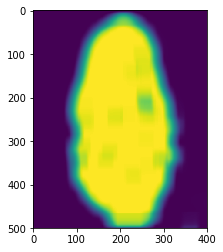

In [20]:
import matplotlib.pyplot as plt
#prob_map = prob_map.reshape(b,a)
print(prob_map_raw.shape)
plt.imshow(prob_map_raw) 

In [38]:
for i in range(height):
    for j in range(weight):
        img2[i,j] = np.round(img2[i,j]*prob_map_raw[i,j])

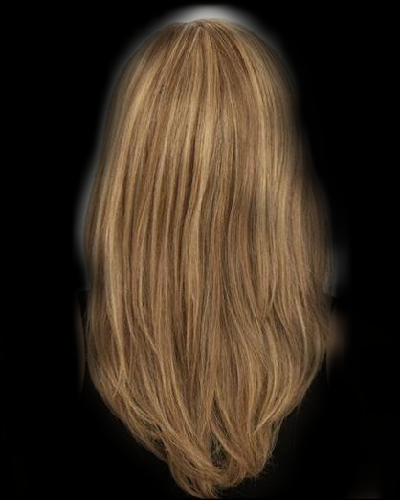

In [40]:
import numpy as np
import PIL
 
# Convert array to Image
img3 = PIL.Image.fromarray(img2)
img3

# Step2) 머리 염색하기 (앞의 분류기에 Texture data 적용해서 Prob map 도출)

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import PIL
import os 
os.chdir('C:\\Users\\이보근\\Desktop\\빅데이터연구회\\2학기 딥러닝 1조\\프로젝트 자료\\texture')

In [ ]:
import numpy as np
from PIL import Image
import math
img_path = 'C:/Users/이보근/Desktop/빅데이터연구회/2학기 딥러닝 1조/프로젝트 자료/texture/Figaro1k/Figaro1k/Original/Training'
img = Image.open(img_path + '/Frame00001-org.jpg')
img = img.resize((400, 500))

prob_map_raw = np.load('prob_map.npy')

img_origin = np.array(img)
img_dye = np.array(img)
img_final = np.zeros((500,400,3))

height = img_origin.shape[0]
weight = img_origin.shape[1]

for i in range(height):
    for j in range(weight):
        img_dye[i,j,0] = 0*img_dye[i,j,0]
        img_dye[i,j,1] = 0.278*img_dye[i,j,1]
        img_dye[i,j,2] = 0.671*img_dye[i,j,2]

prob = np.repeat(prob_map_raw, 3).reshape((500,400,3))

In [ ]:
# origin 과 dye의 weighted sum
img_final = img_origin*(1-prob) + img_dye*prob
img_final = img_final.astype(int)
plt.imshow(img_final)

In [ ]:
# 방법 1 : 각 사진의 영향력을 더 확실하게 해준다.
w = 1-prob**2

In [ ]:
# 방법 2 : LBP개념 사용
w_k = np.array([[1,1,1],
               [1,0,1],
               [1,1,1]])/9
prob_mab_lbp = signal.convolve2d(prob_map_raw, w_k, 'same')

In [ ]:
염색(원본이미지, prob_map, r비율, g비율, b비율)